# Experimentos y análisis


In [16]:
from matplotlib import pyplot as plt
import pandas as pd
import subprocess
import os

CPU_EXEC = "../build/src/MyProjectCPU"
CL_EXEC = "../build/src/cl/MyProjectCL"
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"

## Experimento 1
Número de células evaluadas por segundo para varios tamaños de grilla $N \times M$

Variar el tamaño de la grilla con `block/local size` fijos, 1000 iteraciones y sin usar `ifs`. `grid/global size` se calculan en el programa.

- Párametros:
    - Tamaño de grilla $N\times M$: Grillas cuadradas de tamaño $2^{10}$ a $2^{28}$ (incrementos de 2). De esta manera se usa de $2*1$ KB hasta $2*2^{8}$ MB de memoria ($0.5$ GB) (Se multiplica por 2 porque se necesitan tener 2 copias del mundo en memoria)

In [17]:
current_path = os.getcwd()
block = 32
iterations = 100

for i in range(5, 14+1):
    N = 2**i
    M = 2**i
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(10):
        # CPU:                      <world width>   <world height>  <iterations>        <output_file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CPU_EXEC,   str(N),         str(M),         str(iterations),    current_path + "/cpu.csv",  str(0),         str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

Running for size 1024
Running for size 4096
Running for size 16384
Running for size 65536
Running for size 262144
Running for size 1048576
Running for size 4194304
Running for size 16777216


KeyboardInterrupt: 

### Análisis

In [29]:
# read from csv and add correct columns
cpu = pd.read_csv("cpu.csv", header=None)
cl = pd.read_csv("cl.csv", header=None)
cuda = pd.read_csv("cuda.csv", header=None)

cpu.columns = ["width", "height", "iterations", "data creation time", "execution time", "total time"]
cpu["size"] = cpu["width"] * cpu["height"]
cpu.drop(columns=["width", "height"], inplace=True)
cl.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CPU")
print(cpu)
print("CL")
print(cl)
print("CUDA")
print(cuda)

CPU
    iterations  data creation time  execution time  total time      size
0          100                  21            3887        3908      1024
1          100                  17            2753        2770      1024
2          100                  17            2598        2615      1024
3          100                  17            3423        3440      1024
4          100                  17            2734        2751      1024
..         ...                 ...             ...         ...       ...
74         100              294180        47652431    47946611  16777216
75         100              302277        47742895    48045172  16777216
76         100              326042        48608148    48934190  16777216
77         100              282977        46859998    47142975  16777216
78         100              293137        45502385    45795522  16777216

[79 rows x 5 columns]
CL
        size  block size  if use  iterations  data creation time  \
0       1024          32  

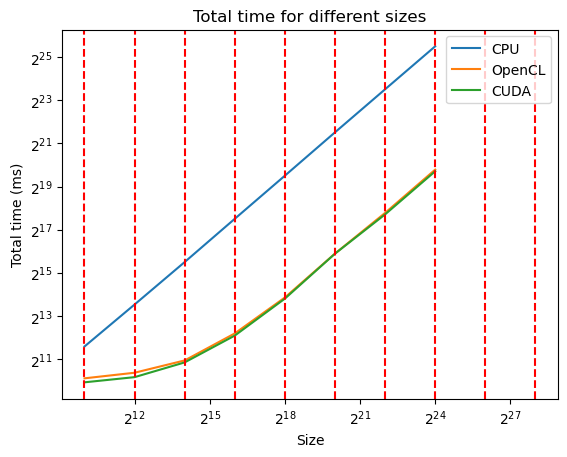

In [34]:
# plot avg total time for each size
cpu_avg = cpu.groupby("size").mean()
cl_avg = cl.groupby("size").mean()
cuda_avg = cuda.groupby("size").mean()

fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["total time"], label="CPU")
ax.plot(cl_avg.index, cl_avg["total time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["total time"], label="CUDA")
# plot vertical isolines of power of 2
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different sizes")
plt.show()

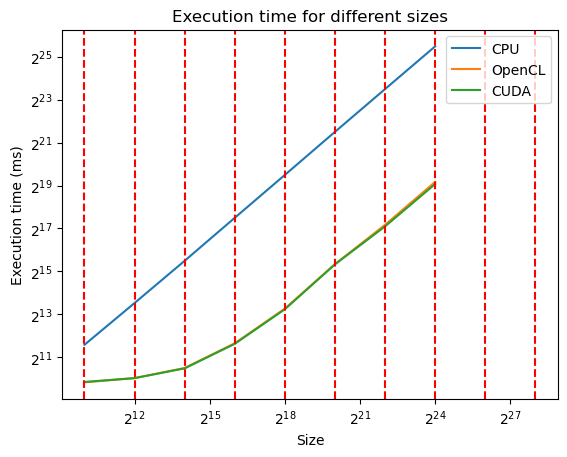

In [36]:
# plot avg execution time for each size
fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["execution time"], label="CPU")
ax.plot(cl_avg.index, cl_avg["execution time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["execution time"], label="CUDA")
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Execution time (ms)")
ax.legend()
plt.title("Execution time for different sizes")
plt.show()

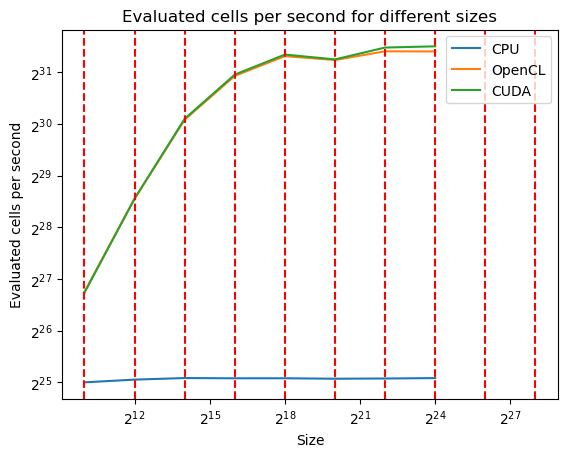

In [41]:
# plot evaluated cells per second for each size

cpu_avg["evaluated cells per second"] = cpu_avg.index*iterations / (cpu_avg["execution time"]/(10**6))
cl_avg["evaluated cells per second"] = cl_avg.index*iterations / (cl_avg["execution time"]/(10**6))
cuda_avg["evaluated cells per second"] = cuda_avg.index*iterations / (cuda_avg["execution time"]/(10**6))

fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["evaluated cells per second"], label="CPU")
ax.plot(cl_avg.index, cl_avg["evaluated cells per second"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["evaluated cells per second"], label="CUDA")
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Evaluated cells per second")
ax.legend()
plt.title("Evaluated cells per second for different sizes")
plt.show()





In [42]:
# print speedup on execution time
speedup_cl = cpu_avg["execution time"] / cl_avg["execution time"]
speedup_cuda = cpu_avg["execution time"] / cuda_avg["execution time"]

print("Speedup OpenCL")
print(speedup_cl)
print("Speedup CUDA")
print(speedup_cuda)

Speedup OpenCL
size
1024         3.366810
4096        11.338509
16384       31.995622
65536       57.776593
262144      75.264309
1048576     71.899032
4194304     80.552143
16777216    79.967135
Name: execution time, dtype: float64
Speedup CUDA
size
1024         3.328927
4096        11.337416
16384       32.394076
65536       58.783833
262144      76.872909
1048576     72.491446
4194304     84.722084
16777216    85.657133
Name: execution time, dtype: float64


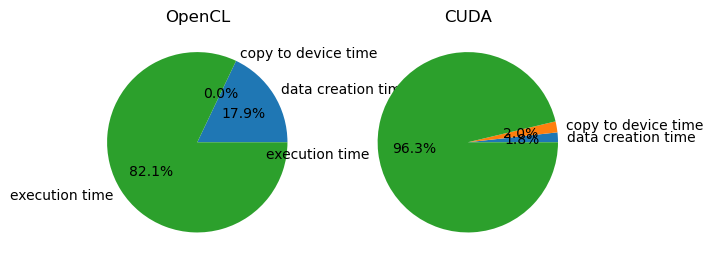

In [43]:
cl_avg["data creation time"] /= cl_avg.index
cl_avg["copy to device time"] /= cl_avg.index
cl_avg["execution time"] /= cl_avg.index
cl_avg["copy to host time"] /= cl_avg.index

cuda_avg["data creation time"] /= cuda_avg.index
cuda_avg["copy to device time"] /= cuda_avg.index
cuda_avg["execution time"] /= cuda_avg.index
cuda_avg["copy to host time"] /= cuda_avg.index

# plot a two pie chart of the average time spent on each step for OpenCL and CUDA
fig, ax = plt.subplots(1, 2)
ax[0].pie(cl_avg.iloc[0][3:6], labels=cl_avg.columns[3:6], autopct='%1.1f%%')
ax[0].set_title("OpenCL")
ax[1].pie(cuda_avg.iloc[0][3:6], labels=cuda_avg.columns[3:6], autopct='%1.1f%%')
ax[1].set_title("CUDA")
plt.show()

### Conclusión
- Para arreglos de tamaño menor o igual a $2^{20}$ el rendimiento en CPU y GPU es similar
- Existen un gran speedup en *tiempo de ejecución* no asi en *tiempo total* del programa
- En OpenCL el mayor problema esta en el paso de memoria de CPU a GPU.
- En CUDA también se repite este problema pero esta más equilibrado.

## Experimento 2
Número de células evaluadas por segundo utilizando ifs (condicionales) para preguntar por la vecindad.  

Utilizar `ifs`, dejar fijo el tamaño de `block/local size` con tamaño de grilla variable, iteraciones fijas (1000) y sin usar `grid/global size` se calculan en el programa.

- Párametros:
    - Comparar la activación de los ifs:  
        - Activado (1)  
        - Desactivado (0)
    - Tamaño de grilla $N\times M$: Grillas cuadradas de tamaño $2^{10}$ a $2^{28}$ (incrementos de 2). De esta manera se usa de $2*1$ KB hasta $2*2^{8}$ MB de memoria ($0.5$ GB) (Se multiplica por 2 porque se necesitan tener 2 copias del mundo en memoria)

In [ ]:
current_path = os.getcwd()
iterations = 100

for i in range(10):
    N = 2**(10+2*i)
    M = 2**(10+2*i)
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(10):
        # CPU:                      <world width>   <world height>  <iterations>        <output_file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CPU_EXEC,   str(N),         str(M),         str(iterations),    current_path + "/cpu_if.csv",  str(0),         str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_if.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_if.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

    for _ in range(10):
        # No corremos CPU por segunda vez ya que no tiene opcion para ifs
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_if.csv",   str(0),         str(1)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_if.csv", str(0),         str(1)], stdout=subprocess.DEVNULL)

In [ ]:
# read from csv and add correct columns
cpu_if = pd.read_csv("cpu_if.csv", header=None)
cl_if = pd.read_csv("cl_if.csv", header=None)
cuda_if = pd.read_csv("cuda_if.csv", header=None)

cpu_if.columns = ["width", "height", "iterations", "data creation time", "execution time", "total time"]
cpu_if["size"] = cpu_if["width"] * cpu_if["height"]
cpu_if.drop(columns=["width", "height"], inplace=True)
cl_if.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda_if.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

#Separamos parametros
cl_if_off = cl_if[cl_if["if use"] == 0]
cl_if_on = cl_if[cl_if["if use"] == 1]

cuda_if_off = cuda_if[cuda_if["if use"] == 0]
cuda_if_on = cuda_if[cuda_if["if use"] == 1]

print("CPU")
print(cpu_if)
print("CL")
print(cl_if)
print("CUDA")
print(cuda_if)

In [ ]:
#Ploteamos
# Calculate average total time by size
cpu_if_avg = cpu_if.groupby("size").mean()
cl_if_off_avg = cl_if_off.groupby("size").mean()
cl_if_on_avg = cl_if_on.groupby("size").mean()
cuda_if_off_avg = cuda_if_off.groupby("size").mean()
cuda_if_on_avg = cuda_if_on.groupby("size").mean()

# Plotting
fig, ax = plt.subplots()

# Plot each dataset
ax.plot(cpu_if_avg.index, cpu_if_avg["total time"], label="CPU")
ax.plot(cl_if_off_avg.index, cl_if_off_avg["total time"], label="OpenCL if off")
ax.plot(cl_if_on_avg.index, cl_if_on_avg["total time"], label="OpenCL if on")
ax.plot(cuda_if_off_avg.index, cuda_if_off_avg["total time"], label="CUDA if off")
ax.plot(cuda_if_on_avg.index, cuda_if_on_avg["total time"], label="CUDA if on")

# Plot vertical isolines of power of 2
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

# Set log scales
ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)

# Add labels, title, and legend
ax.set_xlabel("Size")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different sizes")

# Show plot
plt.show()

## Experimento 3
Número de células evaluadas por segundo para varios tamaños de bloque

Variar el tamaño de `block/local size` con tamaño de grilla fijo $2^{20}$, iteraciones fijas y sin usar `ifs`. `grid/global size` se calculan en el programa.

- Párametros:
    - Tamaño de bloque:
    
        - Primero usando 6 múltiplos de 32:     32, 64, 128, 256, 512, 1024
    
        - Luego usando 6 no múltiplos de 32:  24, 48, 96, 192, 384, 768

In [45]:
current_path = os.getcwd()
iterations = 100
N = 2**10
M = 2**10

for i in range(1, 6+1):
    block = i * 32
    print("Running for block size", block)
    # do 10 runs for each size
    for _ in range(10):
        # CPU:                      <world width>   <world height>  <iterations>        <output_file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CPU_EXEC,   str(N),         str(M),         str(iterations),    current_path + "/cpu_block.csv",  str(0),         str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_block.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_block.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

for i in range(1, 6+1):
    block = i * 24
    print("Running for block size", block)
    # do 10 runs for each size
    for _ in range(10):
        # CPU:                      <world width>   <world height>  <iterations>        <output_file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CPU_EXEC,   str(N),         str(M),         str(iterations),    current_path + "/cpu_block.csv",  str(0),         str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_block.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_block.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)



Running for block size 32
Running for block size 64
Running for block size 96
Running for block size 128


KeyboardInterrupt: 